In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelBinarizer
#from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from scipy import interp
from sklearn.model_selection import KFold
#from sklearn.preprocessing import StandardScaler
import os
os.chdir('/home/roman/Documents/Projects/Cost_Sensitive')

In [30]:
# Prepare data (y_train and y_test)
data = pd.read_csv('data/creditcard.csv')
y = data.iloc[:, -1]
n_splits = 5
kf = KFold(n_splits=n_splits, random_state=123, shuffle=True)
kf.get_n_splits(y)
y_train_l, y_test_l = [], []
for train_index, test_index in kf.split(y):
    y_train_l.append(y.iloc[train_index])
    y_test_l.append(y.iloc[test_index])
# load results:
y_pred_train_lr = np.load('results/y_pred_train_lr.npy')
y_pred_test_lr = np.load('results/y_pred_test_lr.npy')
y_pred_train_lr_probas = np.load('results/y_pred_train_lr_probas.npy')
y_pred_test_lr_probas = np.load('results/y_pred_test_lr_probas.npy')
y_pred_train_ann = np.load('results/y_pred_train_ann.npy')
y_pred_test_ann = np.load('results/y_pred_test_ann.npy')
y_pred_train_ann_probas = np.load('results/y_pred_train_ann_probas.npy')
y_pred_test_ann_probas = np.load('results/y_pred_test_ann_probas.npy')
y_pred_train_ann_cs = np.load('results/y_pred_train_ann_cs.npy')
y_pred_test_ann_cs = np.load('results/y_pred_test_ann_cs.npy')
y_pred_train_ann_cs_probas = np.load('results/y_pred_train_ann_cs_probas.npy')
y_pred_test_ann_cs_probas = np.load('results/y_pred_test_ann_cs_probas.npy')

In [85]:
# ROC curves
def stack_y_probas(y_proba):
    y_proba = np.hstack((y_proba, 1 - y_proba))
    return np.array([y_proba[:int(y_proba.shape[0]/2)], y_proba[int(y_proba.shape[0]/2):]]).T
y_test_2D = []
for y_test in y_test_l:
    y_test = LabelBinarizer().fit_transform(y_test)
    y_test = np.hstack((y_test, 1 - y_test))
    y_test_2D.append(y_test)
y_pred_test_lr_probas_2D, y_pred_test_ann_probas_2D, y_pred_test_ann_cs_probas_2D = [], [], []
for i in range(n_splits):
    y_pred_test_lr_probas_2D.append(stack_y_probas(y_pred_test_lr_probas[i]))
    y_pred_test_ann_probas_2D.append(stack_y_probas(y_pred_test_ann_probas[i]))
    y_pred_test_ann_cs_probas_2D.append(stack_y_probas(y_pred_test_ann_cs_probas[i]))

In [83]:
y_pred_test_ann_probas_2D[0]

In [87]:
def create_roc_auc(y_true, y_pred):
    # Compute ROC curve and ROC area for each class
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return fpr, tpr, roc_auc

In [88]:
fpr_lr, tpr_lr, roc_auc_lr = [], [], []
for y_true, y_pred in zip(y_test_2D, y_pred_test_lr_probas_2D):
    fpr, tpr, roc_auc = create_roc_auc(y_true, y_pred)
    fpr_lr.append(fpr)
    tpr_lr.append(tpr)
    roc_auc_lr.append(roc_auc)
fpr_lr_mean = np.mean

In [114]:
#np.mean([fpr_lr[0], fpr_lr[1]], axis=0)
#f=[fpr[1] for fpr in fpr_lr]
t=[tpr[1] for tpr in tpr_lr]
t[0]#[3]-f[0][2]

array([0.        , 0.77995321, 0.94645276, 0.97385966, 0.98393935,
       0.98967404, 0.99248861, 0.99454677, 0.99579573, 0.99667529,
       0.99720302, 0.99769557, 0.99794184, 0.99806498, 0.99815294,
       0.99836403, 0.99846958, 0.99857512, 0.9986279 , 0.99868067,
       0.99871585, 0.99876862, 0.99878622, 0.99880381, 0.99885658,
       0.99887417, 0.99890935, 0.99896213, 0.99896213, 0.99903249,
       0.99908526, 0.99912045, 0.99915563, 0.99917322, 0.9992084 ,
       0.99926117, 0.99927877, 0.99931395, 0.99931395, 0.99934913,
       0.99934913, 0.99936672, 0.99943709, 0.99943709, 0.99947227,
       0.99948986, 0.99948986, 0.99950745, 0.99950745, 0.99954263,
       0.99954263, 0.99957781, 0.99959541, 0.99959541, 0.999613  ,
       0.999613  , 0.99966577, 0.99970095, 0.99970095, 0.99975372,
       0.99975372, 0.99977132, 0.99977132, 0.99978891, 0.99978891,
       0.99982409, 0.99982409, 0.99984168, 0.99984168, 0.99985927,
       0.99985927, 0.99987686, 0.99987686, 0.99987686, 0.99989

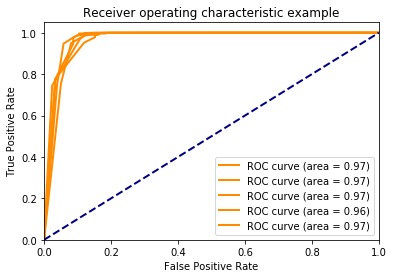

In [117]:
fpr = fpr_lr[2]
tpr = tpr_lr[2]
roc_auc = roc_auc_lr[2]
plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])

fpr = fpr_lr[0]
tpr = tpr_lr[0]
roc_auc = roc_auc_lr[0]
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])

fpr = fpr_lr[1]
tpr = tpr_lr[1]
roc_auc = roc_auc_lr[1]
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
fpr = fpr_lr[3]
tpr = tpr_lr[3]
roc_auc = roc_auc_lr[3]
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
fpr = fpr_lr[4]
tpr = tpr_lr[4]
roc_auc = roc_auc_lr[4]
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [107]:
?auc